In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
df_phq = pd.read_csv("dataset/dataset/survey/PHQ-9.csv")

score_map = {
    'Not at all': 0, 
    'Several days': 1,
    'More than half the days': 2, 
    'Nearly every day': 3
}

timer = {
    'pre': '2013-03-27',
    'mid': '2013-05-01',
    'post': '2013-06-01'
}

pd.set_option('future.no_silent_downcasting', True)
phq_col = df_phq.columns[2:11]
df_phq[phq_col] = df_phq[phq_col].replace(score_map)

df_phq['timestamp'] = df_phq['type'].map(timer)
df_phq['timestamp'] = pd.to_datetime(df_phq['timestamp'])

df_phq['phq9_total'] = df_phq[phq_col].sum(axis=1)
df_phq['label'] = (df_phq['phq9_total'] >= 10).astype(int)
df_phq

,uid,type,Little interest or pleasure in doing things,"Feeling down, depressed, hopeless.","Trouble falling or staying asleep, or sleeping too much.",Feeling tired or having little energy,Poor appetite or overeating,Feeling bad about yourself or that you are a failure or have let yourself or your family down,"Trouble concentrating on things, such as reading the newspaper or watching television",Moving or speaking so slowly that other people could have noticed. Or the opposite being so figety or restless that you have been moving around a lot more than usual,"Thoughts that you would be better off dead, or of hurting yourself",Response,timestamp,phq9_total,label
0,u00,pre,0,1,0,1,0,0,0,0,0,Not difficult at all,2013-03-27,2,0
1,u01,pre,1,1,1,1,0,1,0,0,0,Very difficult,2013-03-27,5,0
2,u02,pre,2,1,2,2,2,1,1,2,0,Somewhat difficult,2013-03-27,13,1
3,u03,pre,0,1,0,0,0,0,0,1,0,Somewhat difficult,2013-03-27,2,0
4,u04,pre,1,1,0,1,1,1,1,0,0,Somewhat difficult,2013-03-27,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,u52,post,1,3,3,2,3,1,0,1,1,Extremely difficult,2013-06-01,15,1
80,u53,post,0,1,3,2,3,0,2,0,0,Somewhat difficult,2013-06-01,11,1
81,u56,post,0,0,0,2,0,0,1,0,0,Somewhat difficult,2013-06-01,3,0
82,u58,post,0,1,0,2,2,1,1,1,0,Not difficult at all,2013-06-01,8,0


In [3]:
from datetime import timedelta

pl_path = 'dataset/dataset/sensing/phonelock'
pl_features = []

for uid in df_phq['uid'].unique():
    user_file = f"{pl_path}/phonelock_{uid}.csv"
    if not os.path.exists(user_file):
        continue

    df_pl = pd.read_csv(user_file)
    df_pl['start'] = pd.to_datetime(df_pl['start'], unit ='s')
    df_pl['end'] = pd.to_datetime(df_pl['end'], unit='s')
    df_pl['duration'] = (df_pl['end'] - df_pl['start']).dt.total_seconds() / 60
    df_pl['date'] = df_pl['start'].dt.date
    df_pl['start_hr'] = df_pl['start'].dt.hour
    df_pl['night'] = df_pl['start_hr'].apply(lambda h: h >= 23 or h < 6)

    df_user_phq = df_phq[df_phq['uid'] == uid]

    for _, rows in df_user_phq.iterrows():
        survey_time = rows['timestamp']
        window_start = survey_time - timedelta(days=7)
        window_end = survey_time

        df_window = df_pl[(df_pl['start'] >= window_start) & (df_pl['start'] < window_end)]

        if df_window.empty:
            continue

        total_time = df_window['duration'].sum()
        avg_time = df_window['duration'].mean()
        unlocks = df_window.shape[0]
        first_unlock = df_window['start'].dt.hour.min()
        last_unlock = df_window['end'].dt.hour.max()
        night_unlocks = df_window['night'].sum()

        pl_features.append({
            'uid': uid, 
            'phq9_total': rows['phq9_total'], 
            'label': rows['label'], 
            'survey_time': survey_time, 
            'total_time': total_time, 
            'avg_time': avg_time, 
            'unlocks': unlocks, 
            'first_unlock': first_unlock, 
            'last_unlock': last_unlock, 
            'night_unlocks': night_unlocks
        })
        
    
    

In [4]:
df_pl_features = pd.DataFrame(pl_features)
df_pl_features

,uid,phq9_total,label,survey_time,total_time,avg_time,unlocks,first_unlock,last_unlock,night_unlocks
0,u00,3,0,2013-06-01,3391.416667,169.570833,20,0,23,7
1,u01,4,0,2013-06-01,2339.783333,167.127381,14,1,23,4
2,u02,5,0,2013-06-01,2730.400000,182.026667,15,4,23,3
3,u03,2,0,2013-03-27,326.666667,326.666667,1,23,4,1
4,u05,0,0,2013-06-01,971.200000,194.240000,5,5,21,3
5,u09,2,0,2013-06-01,3676.033333,245.068889,15,0,23,8
6,u10,4,0,2013-06-01,4670.633333,194.609722,24,0,23,6
7,u14,3,0,2013-06-01,822.300000,82.230000,10,0,18,6
8,u15,1,0,2013-06-01,238.366667,79.455556,3,1,22,2
9,u16,12,1,2013-06-01,3159.716667,197.482292,16,0,23,5


In [5]:
def package_categories(pkg):
    pkg = str(pkg).lower()
    if 'facebook' in pkg or 'instagram' in pkg or 'snapchat' in pkg or 'twitter' in pkg:
        return 'Social'
    elif 'gmail' in pkg or 'email' in pkg:
        return 'Email'
    elif 'media' in pkg or 'youtube' in pkg or 'video' in pkg:
        return 'Media'
    elif 'whatsapp' in pkg or 'sms' in pkg or 'messaging' in pkg:
        return 'Messaging'
    elif 'chrome' in pkg or 'browser' in pkg or 'webview' in pkg:
        return 'Browser'
    elif 'calendar' in pkg or 'clock' in pkg or 'alarm' in pkg:
        return 'Productivity'
    elif 'launcher' in pkg or 'systemui' in pkg or 'home' in pkg:
        return 'System'
    else:
        return 'Others'

In [6]:
app_path = 'dataset/dataset/app_usage'
app_features = []

for uid in df_phq['uid'].unique():
    user_file = f"{app_path}/running_app_{uid}.csv"
    if not os.path.exists(user_file):
        continue

    df_app = pd.read_csv(user_file)
    df_app['timestamp'] = pd.to_datetime(df_app['timestamp'], unit ='s')
    df_app['date'] = df_app['timestamp'].dt.date
    df_app['hour'] = df_app['timestamp'].dt.hour
    df_app['category'] = df_app['RUNNING_TASKS_topActivity_mPackage'].apply(package_categories)

    df_user_phq = df_phq[df_phq['uid'] == uid]

    for _, rows in df_user_phq.iterrows():
        survey_time = rows['timestamp']
        window_start = survey_time - timedelta(days=7)
        window_end = survey_time

        df_window = df_app[(df_app['timestamp'] >= window_start) & (df_app['timestamp'] < window_end)]

        if df_window.empty:
            continue

        total_app_launches = df_window.shape[0]
        night = df_window[(df_window['hour'] >= 23) | (df_window['hour'] < 6)].shape[0]
        top_apps = df_window['RUNNING_TASKS_topActivity_mPackage'].value_counts()
        most_used = top_apps.idxmax()
        most_used_count = top_apps.max()

        category_counts = df_window['category'].value_counts()

        all_categories = df_window['category'].unique()
        category_features = {
            f'app_usage_{cat.lower()}_count': category_counts.get(cat, 0) 
            for cat in all_categories
        }
        app_entropy = -(df_window['RUNNING_TASKS_topActivity_mPackage']
                       .value_counts(normalize=True)
                       .apply(lambda p: p * np.log2(p + 1e-9)).sum())

        app_features.append({
            'uid': uid, 
            'phq9_total': rows['phq9_total'], 
            'label': rows['label'], 
            'survey_time': survey_time, 
            'total_app_launches': total_app_launches, 
            'night': night, 
            'top_apps': top_apps, 
            'most_used': most_used, 
            'most_used_count': most_used_count, 
            'app_entropy': app_entropy,
            ** category_features
        })

In [7]:
df_app_features = pd.DataFrame(app_features)
df_app_features.fillna(0, inplace=True)
df_app_features

,uid,phq9_total,label,survey_time,total_app_launches,night,top_apps,most_used,most_used_count,app_entropy,app_usage_others_count,app_usage_system_count,app_usage_browser_count,app_usage_productivity_count,app_usage_media_count,app_usage_email_count,app_usage_social_count,app_usage_messaging_count
0,u00,2,0,2013-03-27,1839,475,RUNNING_TASKS_topActivity_mPackage com.android...,com.android.settings,274,4.024161,1390,360,62.0,25.0,2.0,0.0,0.0,0.0
1,u00,3,0,2013-06-01,4642,1520,RUNNING_TASKS_topActivity_mPackage com.android...,com.android.settings,449,3.974955,3154,794,257.0,437.0,0.0,0.0,0.0,0.0
2,u01,5,0,2013-03-27,1228,304,RUNNING_TASKS_topActivity_mPackage com.android...,com.android.settings,378,2.504117,804,216,199.0,9.0,0.0,0.0,0.0,0.0
3,u01,4,0,2013-06-01,1417,398,RUNNING_TASKS_topActivity_mPackage com.android...,com.android.launcher,318,2.917426,855,562,0.0,0.0,0.0,0.0,0.0,0.0
4,u02,13,1,2013-03-27,580,198,RUNNING_TASKS_topActivity_mPackage com.android...,com.android.launcher,168,2.704087,376,181,9.0,11.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,u57,0,0,2013-03-27,5,5,RUNNING_TASKS_topActivity_mPackage org.bewella...,org.bewellapp,1,2.321928,3,1,1.0,0.0,0.0,0.0,0.0,0.0
69,u58,5,0,2013-03-27,21,21,RUNNING_TASKS_topActivity_mPackage com.anddoes...,com.anddoes.launcher,2,3.535175,13,4,2.0,0.0,0.0,0.0,0.0,2.0
70,u58,8,0,2013-06-01,469,146,RUNNING_TASKS_topActivity_mPackage com.android...,com.android.launcher,329,0.897725,140,329,0.0,0.0,0.0,0.0,0.0,0.0
71,u59,5,0,2013-03-27,17,17,RUNNING_TASKS_topActivity_mPackage org.bewella...,org.bewellapp,2,3.499228,11,4,1.0,1.0,0.0,0.0,0.0,0.0


In [8]:
df_final = df_pl_features.merge(
    df_app_features,
    on = ['uid', 'survey_time', 'phq9_total', 'label'],
    how = 'inner'
)

print(df_final.shape)

(29, 24)


In [9]:
from sklearn.model_selection import train_test_split

low_imp = ['app_usage_social_count', 'app_usage_email_count', 'app_usage_messaging_count']
X = df_final.drop(columns=['uid', 'label', 'survey_time', 'most_used', 'top_apps'])
X = X.drop(columns=low_imp)
y = df_final['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

rfc.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = rfc.predict(X_test)
y_prob = rfc.predict_proba(X_test)[:, 1]
y_thresh = (y_prob >= 0.3).astype(int)

print('y_prob: ', y_prob)
print('ROC AUC', roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_thresh))

y_prob:  [0.03666667 0.08       0.08333333 0.06       0.32333333 0.37333333
 0.03       0.15666667]
ROC AUC 1.0
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.50      1.00      0.67         1

    accuracy                           0.88         8
   macro avg       0.75      0.93      0.79         8
weighted avg       0.94      0.88      0.89         8



In [12]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rfc, X, y, cv=skf, scoring='roc_auc')

print('Cross Validated ROC AUC', scores)
print('Mean ROC AUC', scores.mean())

Cross Validated ROC AUC [1.   0.8  1.   1.   0.75]
Mean ROC AUC 0.9099999999999999


In [13]:
rfc.feature_importances_

array([0.33183453, 0.07489108, 0.0727504 , 0.05090352, 0.01637271,
       0.02745136, 0.04130711, 0.04304582, 0.03686728, 0.04068438,
       0.04964142, 0.03370696, 0.04678198, 0.03909248, 0.07772714,
       0.01694182])

In [14]:
import matplotlib.pyplot as plt

importances = rfc.feature_importances_
feature_names = X_train.columns

df_feat = pd.DataFrame({
    'features': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

df_feat

,features,importance
0,phq9_total,0.331835
14,app_usage_productivity_count,0.077727
1,total_time,0.074891
2,avg_time,0.072750
3,unlocks,0.050904
10,app_entropy,0.049641
12,app_usage_system_count,0.046782
7,total_app_launches,0.043046
6,night_unlocks,0.041307
9,most_used_count,0.040684


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


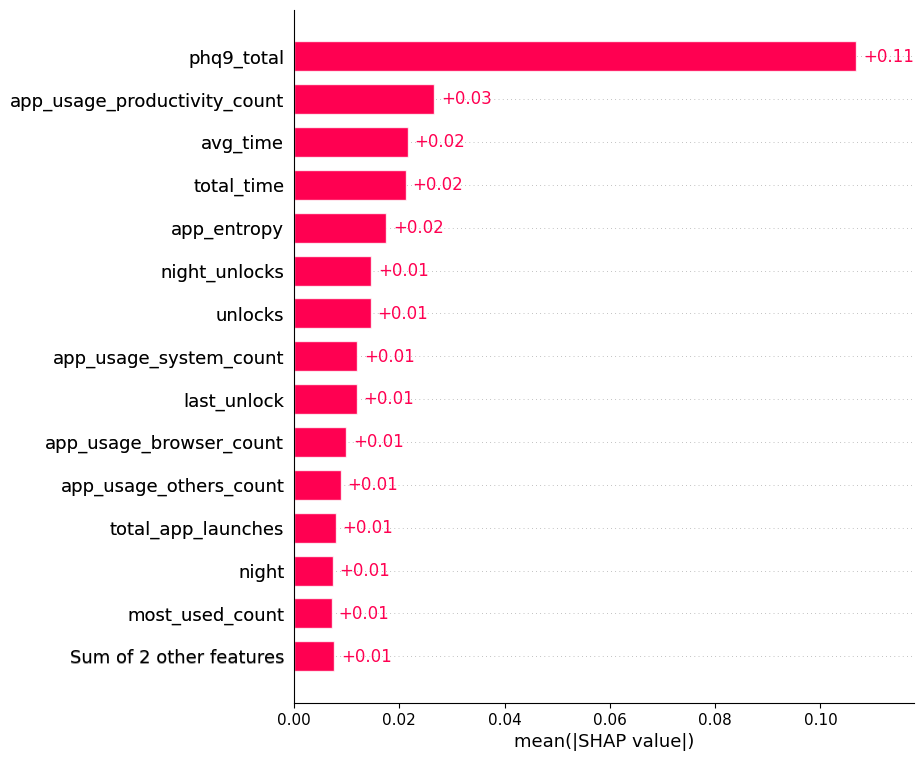

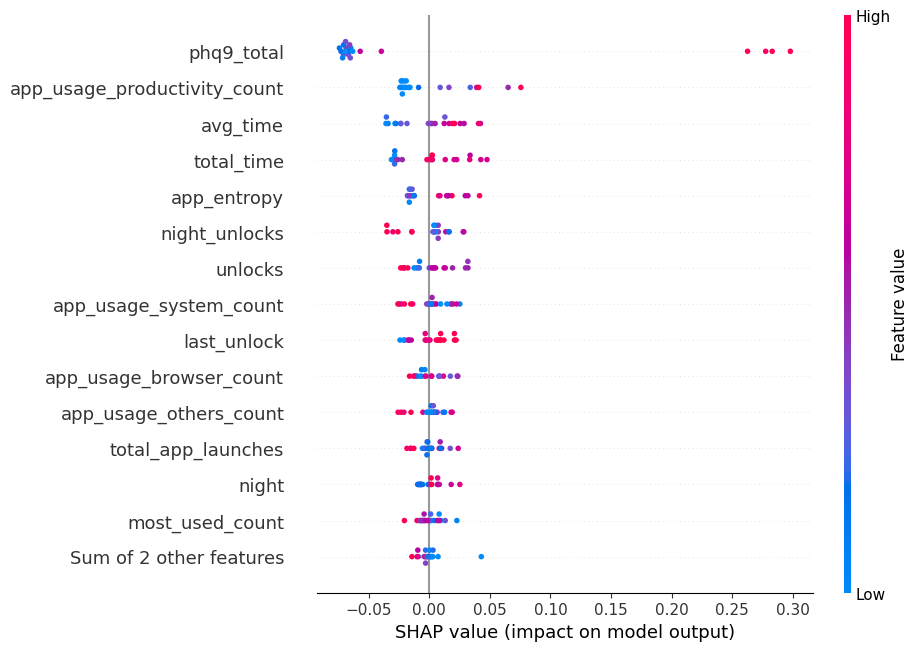

In [15]:
import shap

X_train = X_train.reset_index(drop=True)

explainer = shap.Explainer(rfc, X_train)
shap_values = explainer(X_train)

shap_class1 = shap_values[..., 1]

shap.plots.bar(shap_class1, max_display=15)

shap.plots.beeswarm(shap_class1, max_display=15)

In [16]:
df_final.to_csv("cleaned_studentlife_data.csv", index=False)

In [17]:
import joblib
joblib.dump(rfc, "mental_health_rfc.pkl")

['mental_health_rfc.pkl']